# Module 2 - EDA

## Import libraries

In [ ]:
import os
import boto3
import logging
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Download and load datasets

In [ ]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'

prefixes = [
    "groceries/sampled-datasets/",
    "groceries/box_builder_dataset/"
]

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

for prefix in prefixes:
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    for obj in response.get("Contents", []):
        file_key = obj["Key"]
        if file_key.endswith("/"):  # skip folder placeholders
            continue

        # Strip the first folder ('groceries/') and keep the inner folders
        relative_path = Path(*file_key.split("/")[1:])
        local_path = DATA_DIR / relative_path
        local_path.parent.mkdir(parents=True, exist_ok=True)

        if local_path.exists():
            logging.info(f"Already exists: {local_path}, skipping download.")
        else:
            s3.download_file(bucket_name, file_key, str(local_path))
            logging.info(f"Downloaded {local_path}")

2025-10-04 12:49:04,207 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data


2025-10-04 12:49:04,806 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/abandoned_carts.parquet, skipping download.
2025-10-04 12:49:04,808 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/inventory.parquet, skipping download.
2025-10-04 12:49:04,809 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/orders.parquet, skipping download.
2025-10-04 12:49:04,811 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/regulars.parquet, skipping download.
2025-10-04 12:49:04,814 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/users.parquet, skipping download.
2025-10-04 12:49:04,881 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [131]:
datasets_path = DATA_DIR / "sampled-datasets"

abandoned_carts_df = pd.read_parquet(datasets_path / "abandoned_carts.parquet")
inventory_df = pd.read_parquet(datasets_path / "inventory.parquet")
orders_df = pd.read_parquet(datasets_path / "orders.parquet")
regulars_df = pd.read_parquet(datasets_path / "regulars.parquet")
users_df = pd.read_parquet(datasets_path / "users.parquet")

logging.info("Datasets loaded successfully.")

2025-10-04 12:49:05,010 - INFO - Datasets loaded successfully.


## 1. Understanding the problem space

Understanding the provided datasets is essential to guide our analysis effectively.

### Abandoned carts

In this dataset we obtain the products that were abandoned in the cart, the user who did it and the time.

In [132]:
abandoned_carts_df.head()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


In [133]:
print("Abandoned Carts DataFrame shape:", abandoned_carts_df.shape)
print("Missing values in Abandoned Carts DataFrame:\n", abandoned_carts_df.isnull().sum())

Abandoned Carts DataFrame shape: (5457, 4)
Missing values in Abandoned Carts DataFrame:
 id            0
user_id       0
created_at    0
variant_id    0
dtype: int64


In [134]:
print("Unique users in Abandoned Carts DataFrame:", abandoned_carts_df['user_id'].nunique())

Unique users in Abandoned Carts DataFrame: 3439


There are more `id` than `user_id`, which indicates that some users have left products in their carts more than once. This suggests that cart abandonment may be a common practice. Also, we don't have missing values, so we could identify each of the cases.

### Inventory

In this dataset we get information about each product (`variant_id`).

In [135]:
inventory_df.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [136]:
print("Inventory DataFrame shape:", inventory_df.shape)
print("Missing values in Inventory DataFrame:\n", inventory_df.isnull().sum())

Inventory DataFrame shape: (1733, 6)
Missing values in Inventory DataFrame:
 variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64


In [137]:
inventory_df.describe(include='all')

,variant_id,price,compare_at_price,vendor,product_type,tags
count,1.733000e+03,1733.000000,1733.000000,1733,1733,1733
unique,NaN,NaN,NaN,412,59,1333
top,NaN,NaN,NaN,biona,cleaning-products,[sponges-cloths-gloves]
freq,NaN,NaN,NaN,69,160,18
mean,3.694880e+13,6.307351,7.028881,NaN,NaN,NaN
std,2.725674e+12,7.107218,7.660542,NaN,NaN,NaN
min,3.361529e+13,0.000000,0.000000,NaN,NaN,NaN
25%,3.427657e+13,2.490000,2.850000,NaN,NaN,NaN
50%,3.927260e+13,3.990000,4.490000,NaN,NaN,NaN
75%,3.948318e+13,7.490000,8.210000,NaN,NaN,NaN


In [138]:
print("Duplicated variant_ids in Inventory DataFrame:", inventory_df['variant_id'].duplicated().sum())

Duplicated variant_ids in Inventory DataFrame: 0


In [139]:
inventory_df['price_diff'] = inventory_df['compare_at_price'] - inventory_df['price']
mean_price_diff = inventory_df['price_diff'].mean()
print("Mean difference between price and compare_at_price:", mean_price_diff)

Mean difference between price and compare_at_price: 0.7215291402192728


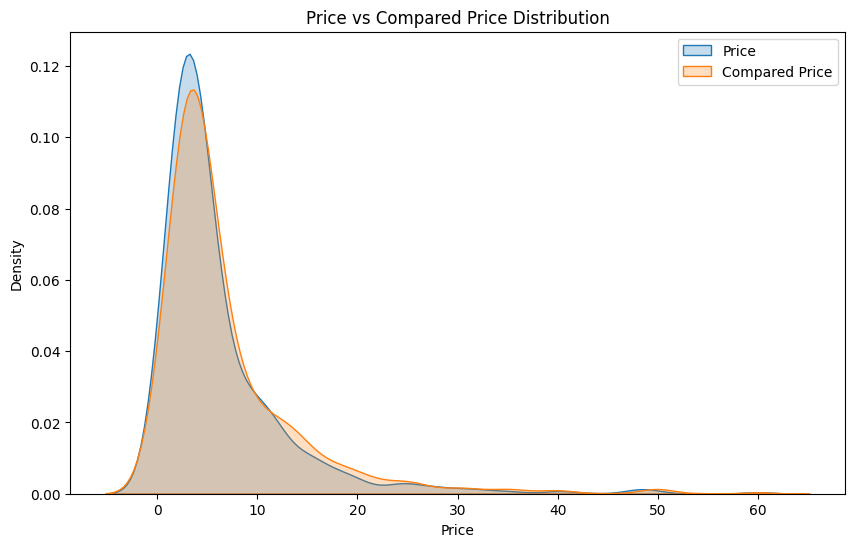

In [140]:
# Compare the price and compared_price distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(inventory_df['price'].dropna(), label='Price', fill=True)
sns.kdeplot(inventory_df['compare_at_price'].dropna(), label='Compared Price', fill=True)
plt.title('Price vs Compared Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

This plot illustrates that many products are sold below their recommended price, indicating that the store is consistently promoting offers and discounts.

### Orders

This dataset is list of the products ordered by a user.

In [141]:
orders_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


In [142]:
print("Orders DataFrame shape:", orders_df.shape)
print("Missing values in Orders DataFrame:\n", orders_df.isnull().sum())

Orders DataFrame shape: (8773, 6)
Missing values in Orders DataFrame:
 id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64


In [143]:
print("Unique users in Orders DataFrame:", orders_df['user_id'].nunique())

Unique users in Orders DataFrame: 4983


Orders per user statistics:
count    4983.000000
mean        1.760586
std         1.936537
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: count, dtype: float64


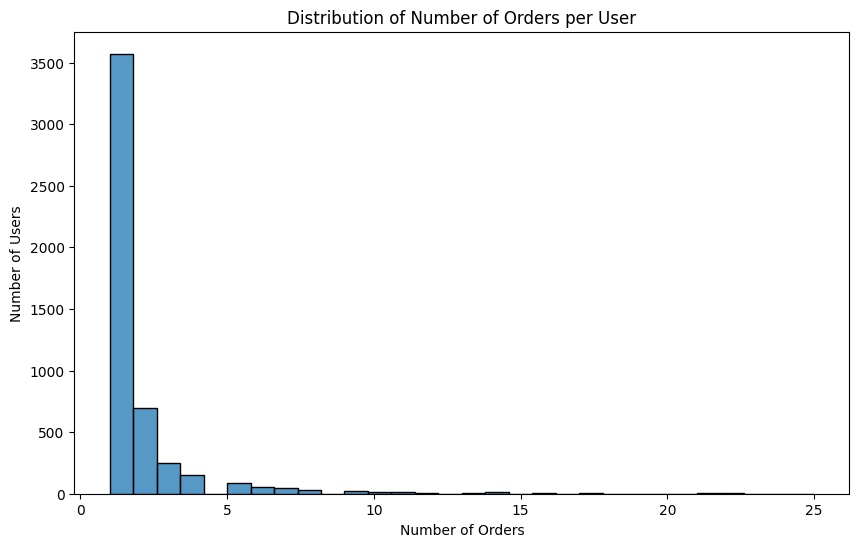

In [144]:
orders_per_user = orders_df['user_id'].value_counts()
print(f"Orders per user statistics:\n{orders_per_user.describe()}")

plt.figure(figsize=(10, 6))
sns.histplot(orders_per_user, bins=30, kde=False)
plt.title('Distribution of Number of Orders per User')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.show()

While most users ordered only once, others use the platform far more frequently, with some placing as many as 25 orders.

### Regulars

Here we obtain the moment when a product was marked as regular by a user.

In [145]:
regulars_df.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


In [146]:
print("Regulars DataFrame shape:", regulars_df.shape)
print("Missing values in Regulars DataFrame:\n", regulars_df.isnull().sum())

Regulars DataFrame shape: (18105, 3)
Missing values in Regulars DataFrame:
 user_id       0
variant_id    0
created_at    0
dtype: int64


In [147]:
print("Unique Regulars DataFrame:", regulars_df['variant_id'].nunique())

Unique Regulars DataFrame: 1843


In [148]:
regulars_per_user = regulars_df['user_id'].value_counts()
print(f"Regulars per user statistics:\n{regulars_per_user.describe()}")

Regulars per user statistics:
count    1448.000000
mean       12.503453
std        36.203697
min         1.000000
25%         1.000000
50%         3.000000
75%        12.000000
max       726.000000
Name: count, dtype: float64


The distribution of regular products per user is highly skewed. While most users keep only a few regular items, typically fewer than 10, the average is pulled up by a small group of outliers, with some users adding hundreds of products.

### Users

In this dataset we have the user information.

In [149]:
users_df.head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [150]:
print("Users DataFrame shape:", users_df.shape)
print("Missing values in Users DataFrame:\n", users_df.isnull().sum())

Users DataFrame shape: (4983, 10)
Missing values in Users DataFrame:
 user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64


In [151]:
users_df.describe(include='all')

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
count,4983,4983,4932,4983,4983,325.000000,325.000000,325.000000,325.000000,325.000000
unique,4983,2,12,4982,24,NaN,NaN,NaN,NaN,NaN
top,d96aadc220f2776037e519f2c3bd4a2f0199658cc45b29...,Top Up,UKI,2021-11-03 19:51:46,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,1,2643,1318,2,688,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.787692,2.003077,0.707692,0.076923,0.636923
std,NaN,NaN,NaN,NaN,NaN,1.365753,0.869577,1.026246,0.289086,0.995603
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,4.000000,2.000000,1.000000,0.000000,1.000000


In [152]:
print(f"Users per segment:\n{users_df['user_segment'].value_counts()}")
print(f"\nUsers per nuts1 region:\n{users_df['user_nuts1'].value_counts()}")

Users per segment:
user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64

Users per nuts1 region:
user_nuts1
UKI    1318
UKJ     745
UKK     602
UKH     414
UKD     358
UKM     315
UKE     303
UKG     295
UKF     252
UKL     224
UKC     102
UKN       4
Name: count, dtype: int64


In [153]:
# Different values in counts
for col in ['count_people', 'count_children', 'count_adults', 'count_babies', 'count_pets']:
    print(f"\nValue counts for {col}:\n{users_df[col].value_counts(dropna=False)}")


Value counts for count_people:
count_people
NaN    4658
2.0      97
3.0      68
4.0      67
1.0      57
5.0      24
6.0       8
0.0       2
7.0       1
8.0       1
Name: count, dtype: int64

Value counts for count_children:
count_children
NaN    4658
0.0     195
2.0      58
1.0      55
3.0      12
4.0       3
5.0       1
6.0       1
Name: count, dtype: int64

Value counts for count_adults:
count_adults
NaN    4658
2.0     201
1.0      71
3.0      32
4.0      11
5.0       5
0.0       3
7.0       1
6.0       1
Name: count, dtype: int64

Value counts for count_babies:
count_babies
NaN    4658
0.0     302
1.0      21
2.0       2
Name: count, dtype: int64

Value counts for count_pets:
count_pets
NaN    4658
0.0     193
1.0      87
2.0      28
3.0       8
4.0       6
5.0       2
6.0       1
Name: count, dtype: int64


Here we can see that several `count` features contain missing values, likely because many users did not provide responses. This results in skewed statistics, since answered fields are heavily outnumbered by unanswered ones.
On the other hand, when looking at user segmentation, we notice that there are slightly more Top Up users than Proposition users. Additionally, the `nuts1` feature highlights that London is the most represented region among customers.

### Abandoned + Inventory

Merging these dataframes we can understand what type of products tend to be abandoned.

In [154]:
abandoned_inventory_df = pd.merge(abandoned_carts_df.explode('variant_id'), inventory_df, left_on='variant_id', right_on='variant_id', how='left')
abandoned_inventory_df.head()

,id,user_id,created_at,variant_id,price,compare_at_price,vendor,product_type,tags,price_diff
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826459287684,NaN,NaN,NaN,NaN,NaN,NaN
1,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826457616516,NaN,NaN,NaN,NaN,NaN,NaN
2,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33667192127620,NaN,NaN,NaN,NaN,NaN,NaN
3,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826412331140,NaN,NaN,NaN,NaN,NaN,NaN
4,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826472558724,3.99,4.09,profusion,cooking-ingredients,"[salt-pepper, vegan]",0.1


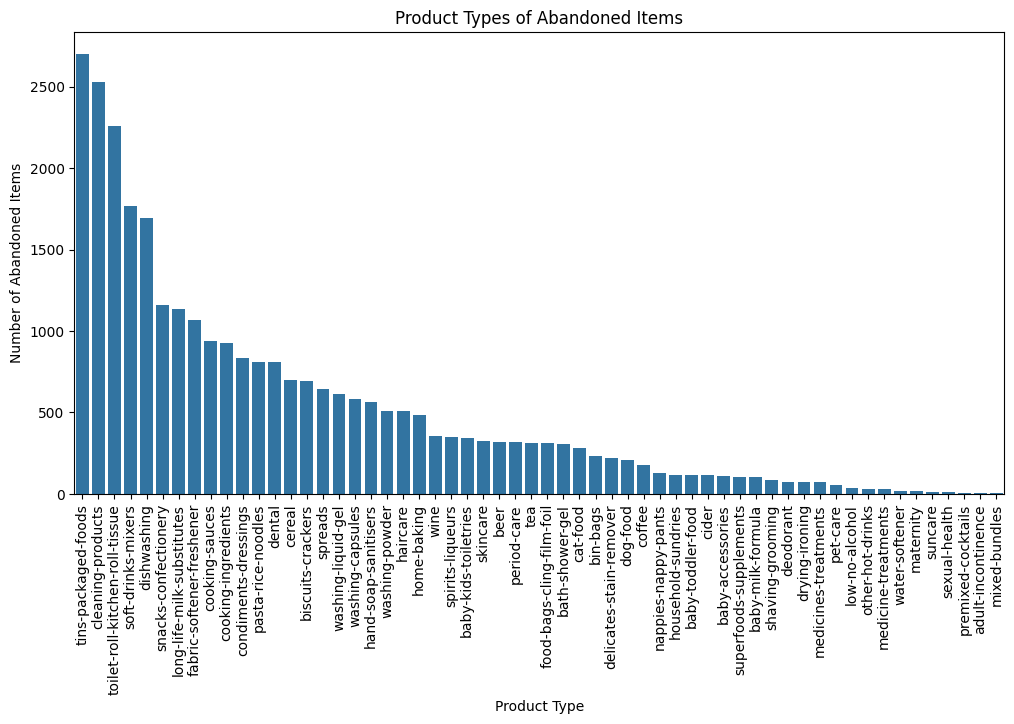

In [155]:
plt.figure(figsize=(12, 6))
sns.countplot(data=abandoned_inventory_df, x='product_type', order=abandoned_inventory_df['product_type'].value_counts().index)
plt.title('Product Types of Abandoned Items')
plt.xlabel('Product Type')
plt.ylabel('Number of Abandoned Items')
plt.xticks(rotation=90)
plt.show()

The products most commonly abandoned in carts are also among the most frequently purchased by users (as shown later). This suggests that these items are popular and in demand, even if they are not always purchased immediately.

### Orders + Users

Joining these dataframes can let us know the type of customer that orders more and which type of product.

In [156]:
user_orders_df = pd.merge(orders_df, users_df, on='user_id', how='left')
user_orders_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045...",Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,4.0,4.0,0.0,0.0,0.0
1,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058...",Proposition,UKM,2020-04-30 17:39:00,2020-04-01 00:00:00,4.0,2.0,2.0,0.0,1.0
2,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618...",Top Up,UKF,2020-04-30 18:12:30,2020-04-01 00:00:00,4.0,2.0,2.0,0.0,1.0
3,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624...",Proposition,UKI,2020-05-01 19:44:11,2020-05-01 00:00:00,4.0,3.0,1.0,0.0,1.0
4,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163...",Proposition,UKI,2020-05-03 21:56:14,2020-05-01 00:00:00,2.0,2.0,0.0,0.0,0.0


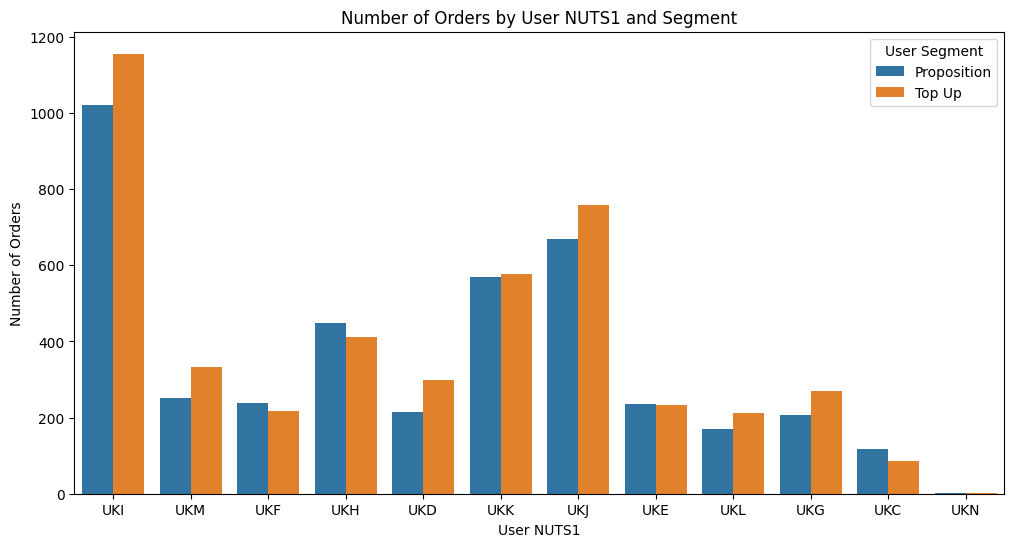

In [157]:
# Plotting the number of orders by user nuts and segment
plt.figure(figsize=(12, 6))
sns.countplot(data=user_orders_df, x='user_nuts1', hue='user_segment')
plt.title('Number of Orders by User NUTS1 and Segment')
plt.xlabel('User NUTS1')
plt.ylabel('Number of Orders')
plt.legend(title='User Segment')
plt.show()

Here, we can see that London stands out as the region with the highest number of orders, with a significant gap compared to the second highest region. The other leading regions are also located in the south. Additionally, the majority of orders were placed by Top Up users.

### Orders + Users + Inventory

Before merging, we have to explode the `ordered_items` feature in order to have only one per row.

In [158]:
user_orders_exploded_df = user_orders_df.explode('ordered_items')
user_orders_inventory_df = pd.merge(user_orders_exploded_df, inventory_df, left_on='ordered_items', right_on='variant_id', how='left')
user_orders_inventory_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,...,count_children,count_babies,count_pets,variant_id,price,compare_at_price,vendor,product_type,tags,price_diff
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


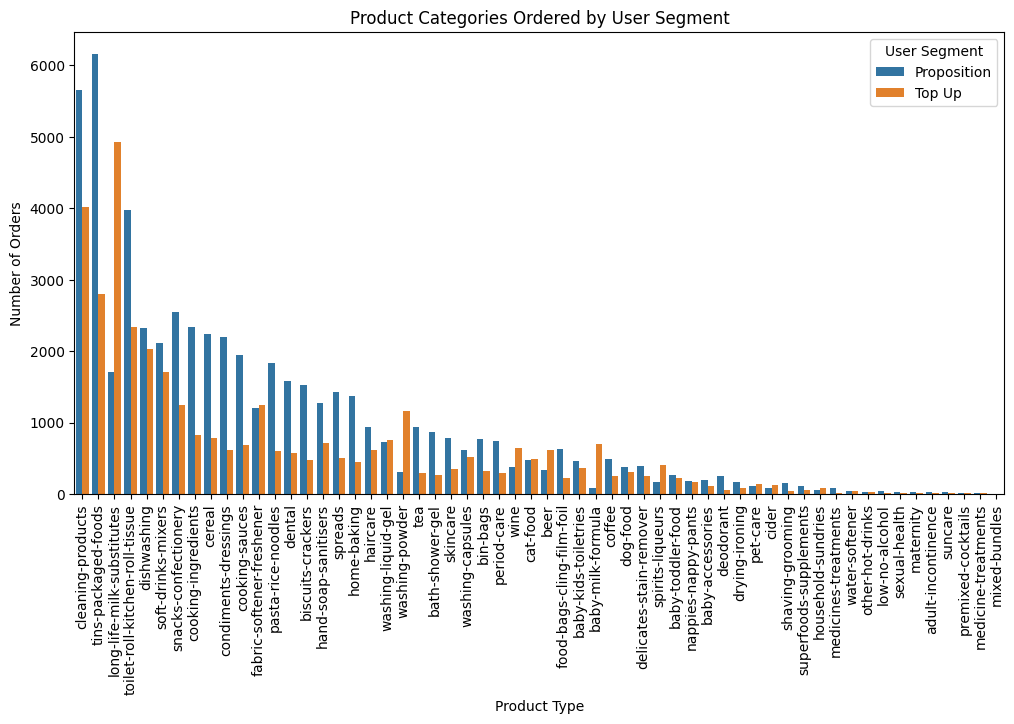

In [159]:
# Plot the distribution of product categories ordered by user segment
plt.figure(figsize=(12, 6))
sns.countplot(data=user_orders_inventory_df, x='product_type', hue='user_segment', order=user_orders_inventory_df['product_type'].value_counts().index)
plt.title('Product Categories Ordered by User Segment')
plt.xlabel('Product Type')
plt.ylabel('Number of Orders')
plt.legend(title='User Segment')
plt.xticks(rotation=90)
plt.show()

Looking at the plot we can see that the most ordered categories were ordered mostly by Proposition Users.

### Regulars + Inventory

With this merge we can get to know with type of products are the regulars.

In [160]:
regulars_inventory_df = regulars_df.merge(inventory_df, on='variant_id', how='left')
regulars_inventory_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags,price_diff
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan, window-glass-cleaner]",0.01


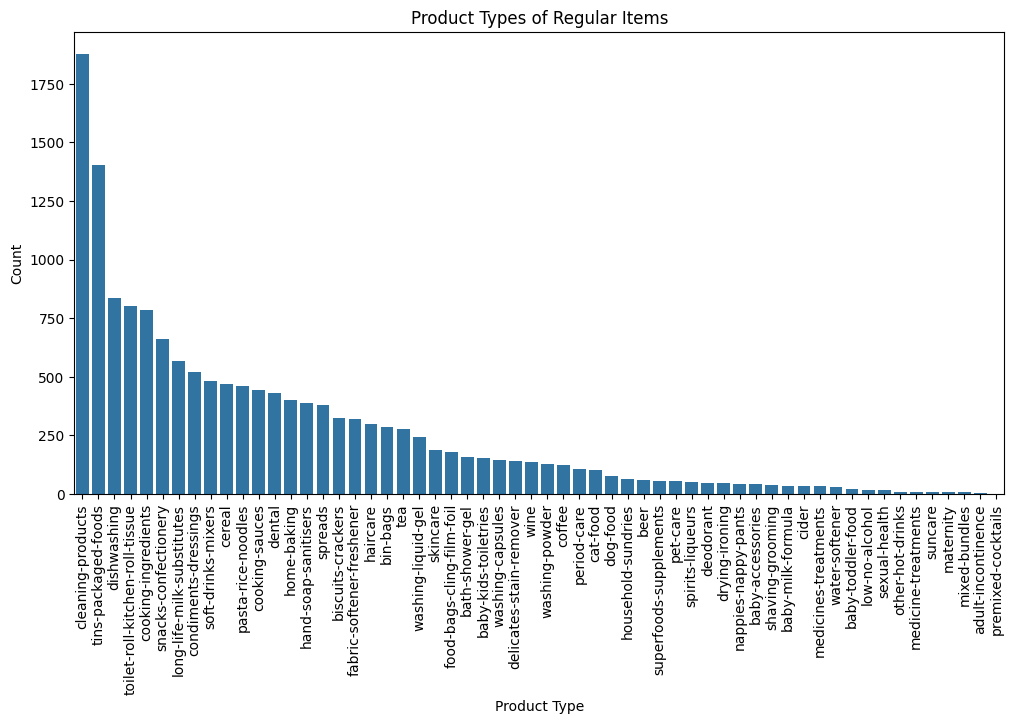

In [161]:
# Plot type of products that are regulars
plt.figure(figsize=(12, 6))
sns.countplot(data=regulars_inventory_df, x='product_type', order=regulars_inventory_df['product_type'].value_counts().index)
plt.title('Product Types of Regular Items')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

The list of regulars looks pretty similar to the most ordered products, which makes sense since the tool is meant to let users easily buy their favorite items again.

### Results

The first takeaways from this analysis are that the most ordered products usually fall within the same categories, showing clear customer preferences. Top Up users are also driving the majority of purchases in the regions with the highest order volumes. Finally, the regulars feature plays a key role, since a large share of orders include regular products, highlighting how important this tool is for customer habits.

## 2. EDA

### Import the dataset

Now, we use the provided dataset to do the EDA.

In [162]:
data = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Errors and sanity checks

In [163]:
print("Feature Frame DataFrame shape:", data.shape)
print(f"Missing values in Feature Frame DataFrame:\n{data.isnull().sum()}")
print("Duplicated rows in Feature Frame DataFrame:", data.duplicated().sum())
print("Unique users in Feature Frame DataFrame:", data['user_id'].nunique())

Feature Frame DataFrame shape: (2880549, 27)
Missing values in Feature Frame DataFrame:
variant_id                          0
product_type                        0
order_id                            0
user_id                             0
created_at                          0
order_date                          0
user_order_seq                      0
outcome                             0
ordered_before                      0
abandoned_before                    0
active_snoozed                      0
set_as_regular                      0
normalised_price                    0
discount_pct                        0
vendor                              0
global_popularity                   0
count_adults                        0
count_children                      0
count_babies                        0
count_pets                          0
people_ex_baby                      0
days_since_purchase_variant_id      0
avg_days_to_buy_variant_id          0
std_days_to_buy_variant_id          0


In [164]:
data.describe(include='all')

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
count,2.880549e+06,2880549,2.880549e+06,2.880549e+06,2880549,2880549,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,...,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06
unique,NaN,62,NaN,NaN,3446,149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,tinspackagedfoods,NaN,NaN,2021-03-03 13:06:52,2021-02-17 00:00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,226474,NaN,NaN,976,68446,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.401250e+13,NaN,2.978388e+12,3.750025e+12,NaN,NaN,3.289342e+00,1.153669e-02,2.113868e-02,6.092589e-04,...,5.492182e-02,3.538562e-03,5.134091e-02,2.072549e+00,3.312961e+01,3.523734e+01,2.645304e+01,3.143513e+01,3.088810e+01,2.594969e+01
std,2.786246e+11,NaN,2.446292e+11,1.775710e+11,NaN,NaN,2.140176e+00,1.067876e-01,1.438466e-01,2.467565e-02,...,3.276586e-01,5.938048e-02,3.013646e-01,3.943659e-01,3.707162e+00,1.057766e+01,7.168323e+00,1.227511e+01,4.330262e+00,3.278860e+00
min,3.361529e+13,NaN,2.807986e+12,3.046041e+12,NaN,NaN,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.414214e+00,0.000000e+00,7.000000e+00,2.828427e+00
25%,3.380354e+13,NaN,2.875152e+12,3.745901e+12,NaN,NaN,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.000000e+01,2.319372e+01,3.000000e+01,2.800000e+01,2.427618e+01
50%,3.397325e+13,NaN,2.902856e+12,3.812775e+12,NaN,NaN,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.400000e+01,2.769305e+01,3.000000e+01,3.100000e+01,2.608188e+01
75%,3.428495e+13,NaN,2.922034e+12,3.874925e+12,NaN,NaN,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,4.000000e+01,3.059484e+01,3.000000e+01,3.400000e+01,2.796118e+01


### Correlations

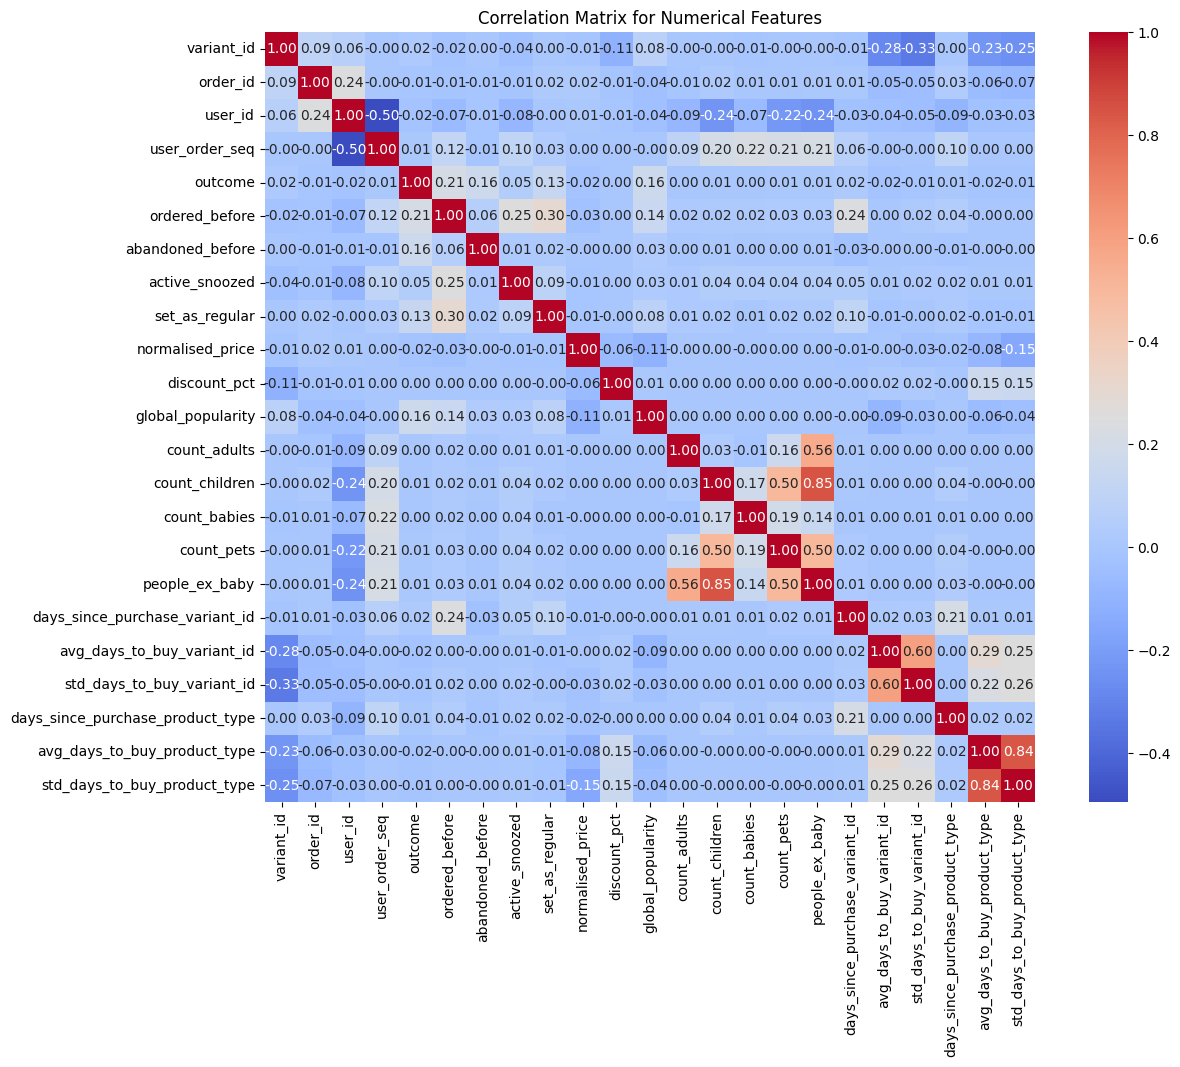

In [ ]:
plt.figure(figsize=(14, 10))
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

There is an interesting correlation between `outcome` and other features such as `ordered_before`, `abandoned_before`, `set_as_regular` and `global_popularity`.
Another important relation could be the one between family information and `user_order_sequence`.
Also, we can see that there is a relation between the number of days to buy a product per type and the discount percetage.
Next, we’ll take a closer look at these relationships to better understand the patterns behind them.

### Data integrity

In [166]:
print(f"Outcome variable distribution:\n{data['outcome'].value_counts(normalize=True)}")

Outcome variable distribution:
outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64


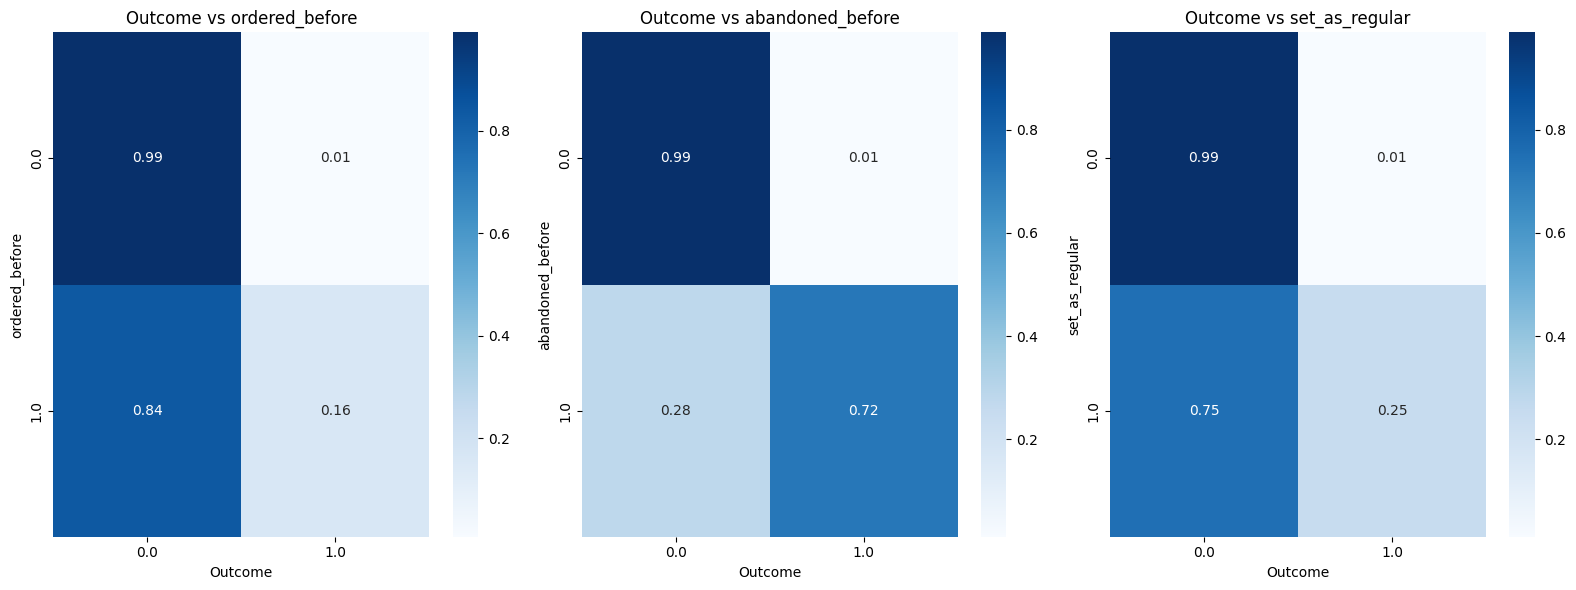

In [167]:
features = ['ordered_before', 'abandoned_before', 'set_as_regular']
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
for i, feature in enumerate(features):
    ax = axes[i]
    crosstab = pd.crosstab(data[feature], data['outcome'], normalize='index')
    sns.heatmap(crosstab, annot=True, fmt=".2f", cmap='Blues', ax=ax)
    ax.set_title(f'Outcome vs {feature}')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(feature)
plt.tight_layout()
plt.show()

These matrices show interesting results:
- `ordered_before`: If something has been ordered before, it is more likely to result as a positive outcome. However, there is a big likelihood to not be ordered.
- `abandoned_before`: If a product has been abandoned before, it is more likely to be purchased than not to. This could mean that people add products to the cart in ordeer to buy them in the future.
- `set_as_regular`: If a product is a regular, it is likely to be ordered but there is a big chance not to.

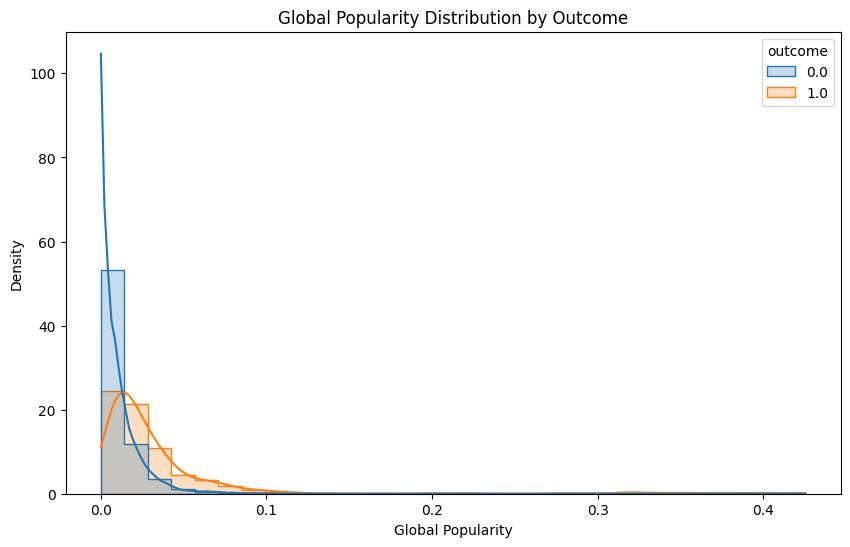

In [168]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='global_popularity', hue='outcome', bins=30, kde=True, element='step', stat='density', common_norm=False)
plt.title('Global Popularity Distribution by Outcome')
plt.xlabel('Global Popularity')
plt.ylabel('Density')
plt.show()

This plot indicates that products more popular tend to have a more positive outcome than the less populars. This makes sense since usually the most popular products are the basics.

2025-10-06 12:30:23,003 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 12:30:24,268 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


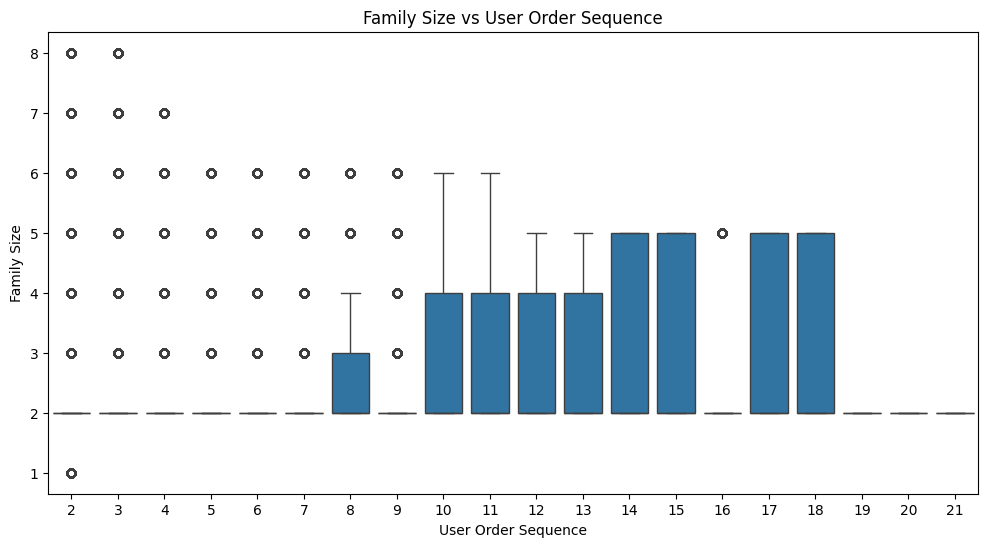

In [187]:
# Create family_size feature
family_info = ['count_children', 'count_adults', 'count_babies', 'count_pets']
family_size = data[family_info].sum(axis=1)
data['family_size'] = family_size

plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='user_order_seq', y='family_size')
plt.title('Family Size vs User Order Sequence')
plt.xlabel('User Order Sequence')
plt.ylabel('Family Size')
plt.show()

The boxplot shows the distribution of family sizes for each user order sequence of supermarket orders. Early order sequences contain families of various sizes, reflected by wider and lower boxes with many outliers, indicating diverse family sizes. For later order sequences, only smaller families appear, resulting in fewer outliers.

/Users/maria/Desktop/Zrive DS/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


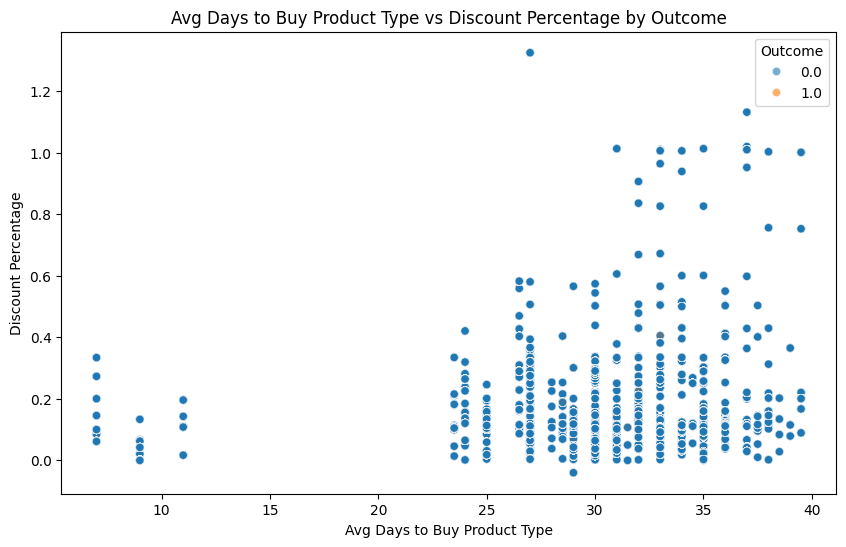

In [176]:
# Plot between avg_days_to_buy_product_type and discount_pct
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='avg_days_to_buy_product_type', y='discount_pct', hue='outcome', alpha=0.6)
plt.title('Avg Days to Buy Product Type vs Discount Percentage by Outcome')
plt.xlabel('Avg Days to Buy Product Type')
plt.ylabel('Discount Percentage')
plt.legend(title='Outcome')
plt.show()

There’s no strong linear relationship between average days to buy and discount percentage. Products bought more frequently tend to have lower or stable discounts, while those purchased less often show higher variability in discounts, that could be due to marketing strategies to boost sales.
Also, there is no big relation to `outcome`, so the discount doesn't seem to be something relevant.

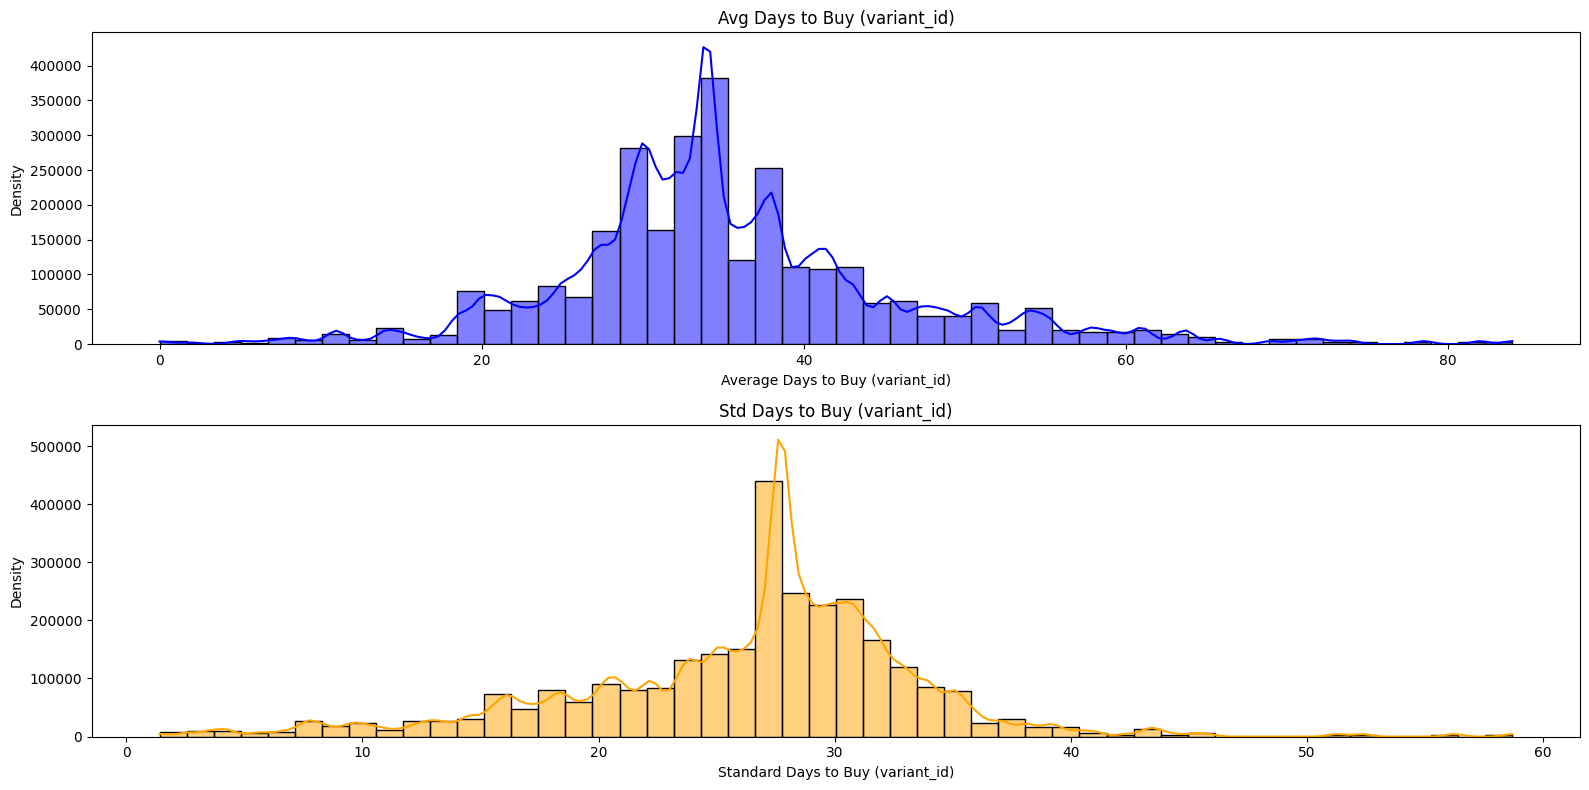

In [169]:
fig, axes = plt.subplots(2,1, figsize=(16, 8))

sns.histplot(data['avg_days_to_buy_variant_id'].dropna(), bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Avg Days to Buy (variant_id)')
axes[0].set_xlabel('Average Days to Buy (variant_id)')
axes[0].set_ylabel('Density')

sns.histplot(data['std_days_to_buy_variant_id'].dropna(), bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Std Days to Buy (variant_id)')
axes[1].set_xlabel('Standard Days to Buy (variant_id)')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

The average plot shows that most products are repurchased within 25 to 40 days, while the standard deviation peaks between 25 and 30 days. This suggests that most products tend to be bought on a monthly basis.

2025-10-06 11:14:02,041 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-06 11:14:03,490 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


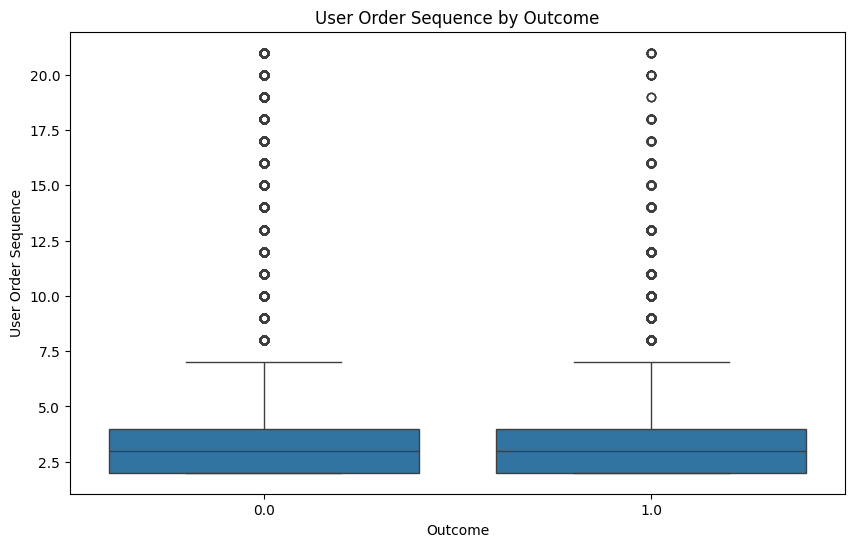

In [172]:
# plot relation between outcome and user_order_seq
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='outcome', y='user_order_seq')
plt.title('User Order Sequence by Outcome')
plt.xlabel('Outcome')
plt.ylabel('User Order Sequence')
plt.show()

The distribution of user order sequences is very similar for both outcomes. Most purchases occur between the second and fourth order, and a few users show more orders. Overall, the order sequence doesn’t seem to strongly influence whether a product is bought or not.

### Conclusions

The analysis reveals some patterns in supermarket ordering behavior. Outcome is moderately correlated with product history: items ordered or set as regular are more likely to be repurchased, while previously abandoned products also show a higher likelihood of future purchase, suggesting shoppers often plan future buys. Product popularity drives positive outcomes and family composition appears to influence ordering dynamics, with sequence patterns shaped by family size, but the impact is not strong enough to fully determine ordering behavior.

In summary, purchase patterns are most shaped by habit and popularity; family size and discounts play a contextual but less decisive role, and most purchases occur in regular intervals of about a month. These insights provide a foundation for identifying key drivers of supermarket buying behavior and targeting future analysis.